This notebook is part of the AI Engineer Track Challenge for Digital Product School. Please see the repository at https://github.com/diksha-shrivastava13/Traffic-Accidents-Model
This notebook contains the models.

## The Necessary Imports, Loading Data and W&B Configuration

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

# NumPy and SciPy
from numpy.random import normal, seed
from scipy.stats import norm

# Scikit-Learn
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Meta Prophet
from prophet import Prophet

In [2]:
# setting up wandb integration
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api")
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("preprocessed_dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv(f"{artifact_dir}/preprocessed_dataset.csv")
wandb.finish()

wandb: Currently logged in as: diksha-shrivastava13. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231203_173430-6taxmrll
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dauntless-frost-26
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/6taxmrll
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run dauntless-frost-26 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/6taxmrll
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231203_173430-6taxmrll/logs


In [4]:
df.head()

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2020,1,28.0,2020-01-01,1,0,0,0,1,0
1,2020,2,40.0,2020-02-01,1,0,0,0,1,0
2,2020,3,27.0,2020-03-01,1,0,0,0,1,0
3,2020,4,26.0,2020-04-01,1,0,0,0,1,0
4,2020,5,40.0,2020-05-01,1,0,0,0,1,0


In [5]:
df.shape

(1764, 10)

In [6]:
df_sorted = df.sort_values(by='Date')
train_percentage = 0.8
split_index = int(len(df_sorted) * train_percentage)
train_set = df_sorted[:split_index]
test_set = df_sorted[split_index:]
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [7]:
train_set

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2000,1,34.0,2000-01-01,0,1,0,1,0,0
1,2000,1,321.0,2000-01-01,0,0,1,0,0,1
2,2000,1,78.0,2000-01-01,1,0,0,0,1,0
3,2000,1,835.0,2000-01-01,0,1,0,0,1,0
4,2000,1,3448.0,2000-01-01,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1406,2016,9,4289.0,2016-09-01,0,0,1,0,1,0
1407,2016,10,448.0,2016-10-01,0,0,1,0,0,1
1408,2016,10,1022.0,2016-10-01,0,1,0,0,1,0
1409,2016,10,11.0,2016-10-01,1,0,0,1,0,0


In [8]:
test_set

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2016,10,44.0,2016-10-01,0,1,0,1,0,0
1,2016,10,30.0,2016-10-01,1,0,0,0,1,0
2,2016,10,559.0,2016-10-01,0,0,1,1,0,0
3,2016,11,489.0,2016-11-01,0,0,1,1,0,0
4,2016,11,7.0,2016-11-01,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
348,2020,12,33.0,2020-12-01,0,1,0,1,0,0
349,2020,12,311.0,2020-12-01,0,0,1,1,0,0
350,2020,12,2661.0,2020-12-01,0,0,1,0,1,0
351,2020,12,13.0,2020-12-01,1,0,0,0,1,0


In [9]:
X_train, y_train = train_set.drop(columns=["Date", "VALUE"]), train_set["VALUE"]
X_test, y_test = test_set.drop(columns=["Date", "VALUE"]), test_set["VALUE"]

In [10]:
np.array(X_train)[0]

array([2000,    1,    0,    1,    0,    1,    0,    0])

In [11]:
np.array(y_train)[0]

34.0

## Linear Regression Model

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_train, y_train)

0.7265788183932369

In [13]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression RMSE: {rmse}")

# Calculate R2 Score
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression R2 Score: {r2}")

Linear Regression RMSE: 653.1732043759321
Linear Regression R2 Score: 0.7170236363575042


In [14]:
print(y_test[0], y_pred[0])

44.0 -115.70965443127625


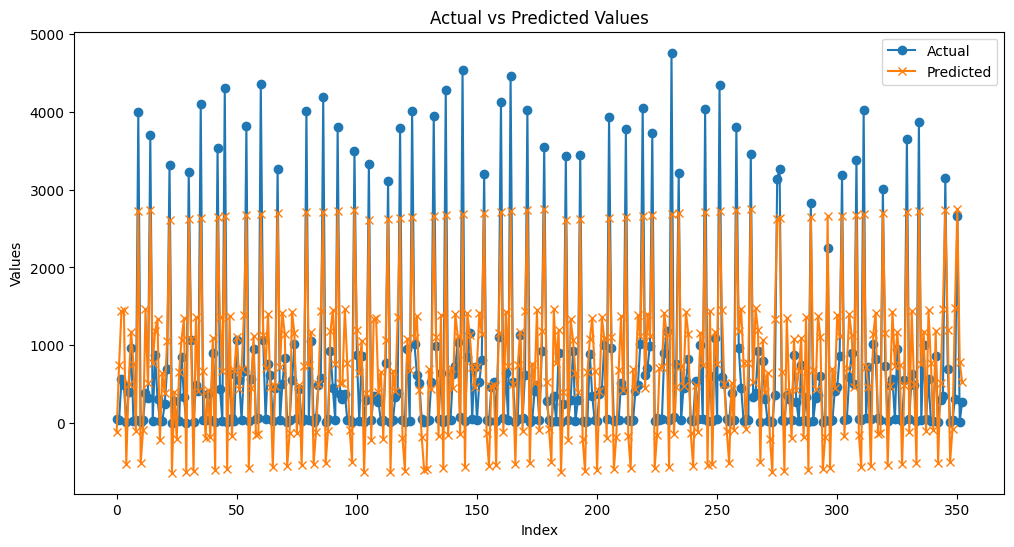

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## Poisson Regression Model

In [16]:
# Fit Poisson Regression model
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Predict on the test set
y_pred = poisson_model.predict(X_test)

# Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(poisson_model.summary())

Root Mean Squared Error: 216.21661476456651
R-squared: 0.9689921561556517
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  VALUE   No. Observations:                 1411
Model:                            GLM   Df Residuals:                     1404
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29120.
Date:                Sun, 03 Dec 2023   Deviance:                       48083.
Time:                        17:35:27   Pearson chi2:                 4.97e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [17]:
print(y_test[0], y_pred[0])

44.0 114.80643060348815


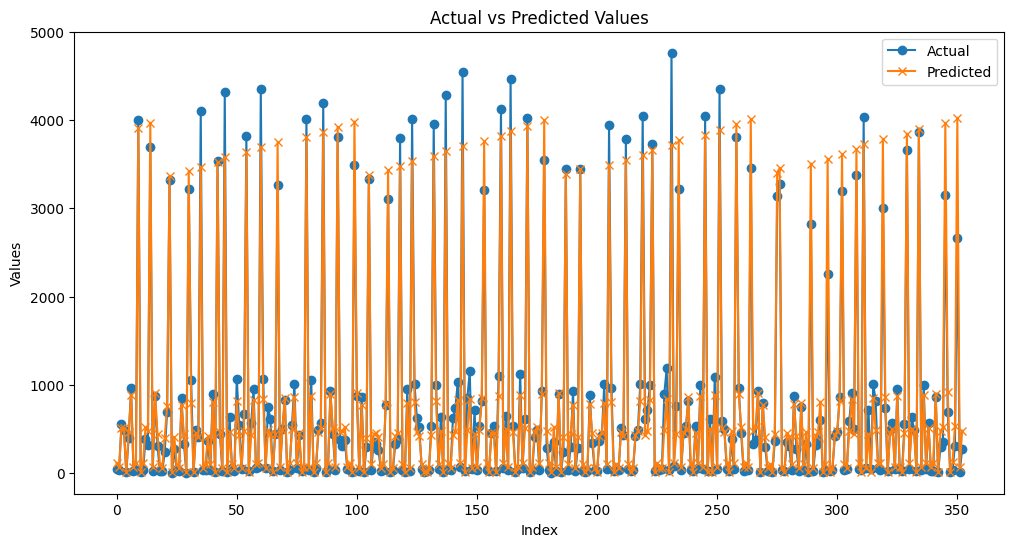

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## Multi-Layer Perceptron Regressor

In [19]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Fit the model
mlp_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp_regressor.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 1227.4699
R-squared (R2) Score: 0.0007


In [20]:
print(y_test[0], y_pred[0])

44.0 809.1365259668698


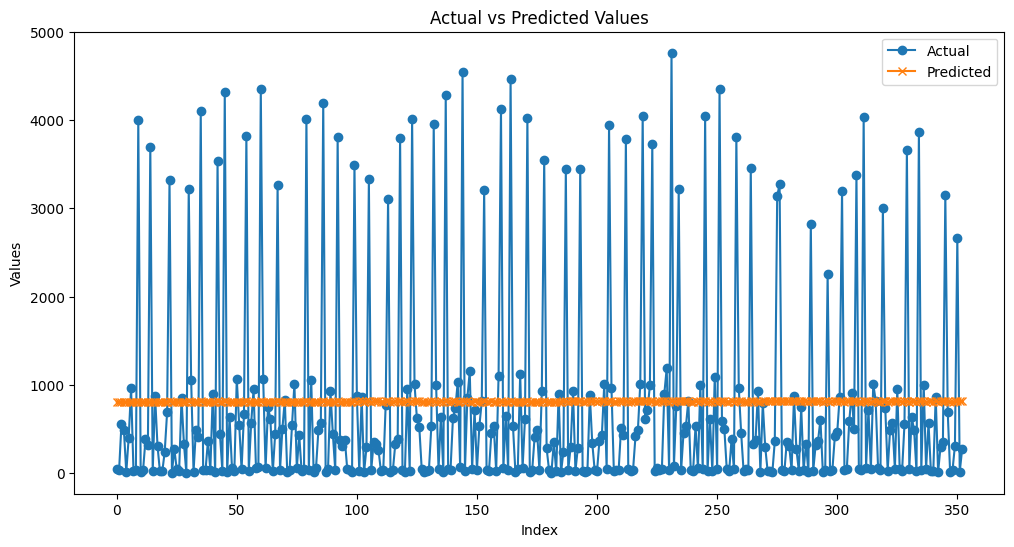

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## XGBoost

In [22]:
from xgboost import XGBRegressor as xgb
import joblib

model = XGBRegressor(
    max_depth=5,
    n_estimators=415,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",  
    verbose=True)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 179.7718
R-squared (R2) Score: 0.9786


In [23]:
model.save_model("model.pkl")
model.save_model('model_file_name.json')

In [24]:
model = xgb()
model.load_model("model_file_name.json")

In [25]:
model.predict(X_test)

array([ 4.42311668e+01,  2.42361298e+01,  6.35841370e+02,  5.15358093e+02,
       -9.09292603e+00,  4.13103516e+02,  9.49155884e+02,  1.32669420e+01,
        2.60111313e+01,  3.98606250e+03, -1.25258360e+01,  3.75070152e+01,
        4.67941528e+02,  3.72439972e+02,  3.86826440e+03,  1.81317863e+01,
        8.81994629e+02,  3.70202271e+02,  3.22685890e+01,  1.62474365e+01,
        2.99178680e+02,  7.76703491e+02,  3.30963696e+03,  1.16786118e+01,
        2.85271332e+02,  2.70578728e+01,  1.27590895e+01,  7.52002014e+02,
        3.49873474e+02,  3.27819824e+00,  3.32608423e+03,  8.92947876e+02,
        2.75094151e+00,  3.77285034e+02,  2.93731445e+02,  3.75647485e+03,
        1.03731413e+01,  3.13202019e+01,  4.77412872e+02,  5.25033760e+01,
        1.00385547e+03,  1.28912544e+01,  4.04455688e+03,  5.53405579e+02,
        4.53703194e+01,  4.00826489e+03,  7.52601337e+00,  6.02313293e+02,
        3.25493011e+01, -2.77232189e+01,  8.92112854e+02,  4.72093994e+02,
        6.03741379e+01,  

In [26]:
!pip install bentoml

  Obtaining dependency information for bentoml from https://files.pythonhosted.org/packages/fc/50/5a1e031d4f664724ee0583b0cca18f483b908eda53dfed41a8506f732290/bentoml-1.1.10-py3-none-any.whl.metadata
  Obtaining dependency information for cattrs<23.2.0,>=22.1.0 from https://files.pythonhosted.org/packages/3a/ba/05df14efaa0624fac6b1510e87f5ce446208d2f6ce50270a89b6268aebfe/cattrs-23.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.5 MB/s eta 0:00:00
  Obtaining dependency information for click-option-group from https://files.pythonhosted.org/packages/af/75/81ea958bc0f7e410257cb2a42531b93a7695a31930cde87192c010a52c50/click_option_group-0.5.6-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.0 MB/s eta 0:00:00
  Obtaining dependency information for httpx from https://files.pythonhosted.org/packages/a2/65/6940eeb21dcb2953778a6895281c179efd9100463ff08cb6232bb6480da7/httpx-0.25.2-py3-none-any.whl.metadata
  Obtai

In [27]:
import bentoml
bento_model = bentoml.xgboost.save_model("my_xgboost_model", model)

In [28]:
loaded_model = bentoml.xgboost.load_model("my_xgboost_model")

In [29]:
loaded_model.predict([[2000,    1,    0,    1,    0,    1,    0,    0]])

array([30.63438], dtype=float32)

In [30]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'int',
                            'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
import xgboost as xgb
import joblib
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Squared Error as the evaluation metric
    'max_depth': 5,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42
}

# Train the XGBoost model
num_rounds = 415  # Number of boosting rounds
xgb_model = xgb.train(params, dtrain, num_rounds)

# Predict on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 179.7718
R-squared (R2) Score: 0.9786


Dumping all the necessary files to build the FastAPI-Streamlit application.

In [32]:
# joblib.dump(regressor, 'model.joblib')
# joblib.dump(one_hot_encoder, 'label_encoder.joblib')
# joblib.dump(features, 'features.joblib')
# joblib.dump(categorical_features, 'categorical_features.joblib')

In [33]:
y_pred_train = xgb_model.predict(dtrain)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 52.4472
R-squared (R2) Score: 0.9980


In [34]:
print(y_test[0], y_pred[0])

44.0 44.231167


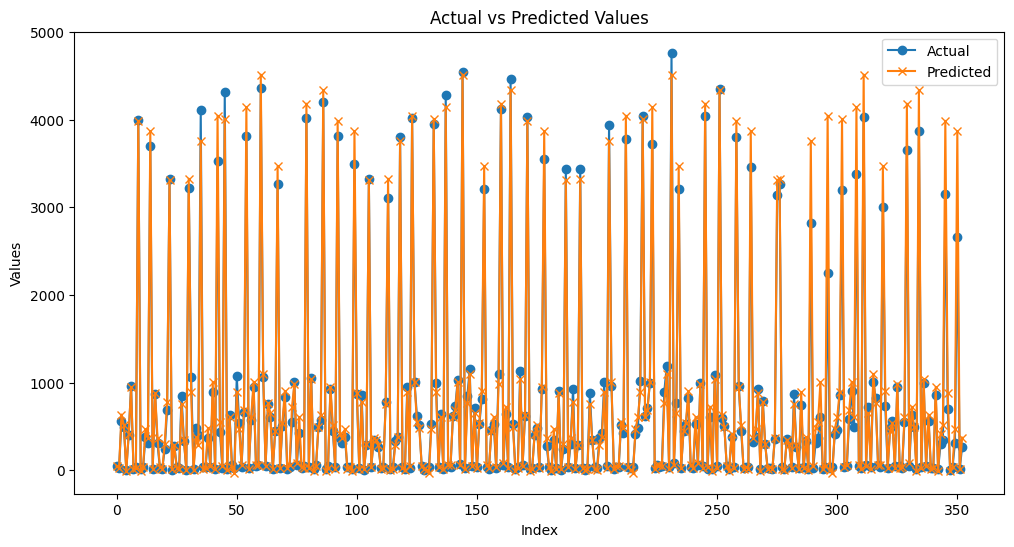

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## LightGBM Model

In [36]:
import lightgbm as lgb

In [37]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # You can use other metrics like 'mse', 'mae', etc.
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=20)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 775.080085
[1]	valid_0's rmse: 1164.92
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 1110.88
[3]	valid_0's rmse: 1053.69
[4]	valid_0's rmse: 1005.04
[5]	valid_0's rmse: 953.29
[6]	valid_0's rmse: 904.256
[7]	valid_0's rmse: 857.761
[8]	valid_0's rmse: 813.63
[9]	valid_0's rmse: 771.884
[10]	valid_0's rmse: 732.198
[11]	valid_0's rmse: 694.781
[12]	valid_0's rmse: 662.951
[13]	valid_0's rmse: 632.821
[14]	v

In [38]:
print(y_test[70], y_pred[70])

831.0 939.4613818226185


In [39]:
y_pred_train = bst.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 115.5612
R-squared (R2) Score: 0.9902


In [40]:
X = df.drop(columns=["Date", "VALUE"])
y = df["VALUE"]

## KFold Validation on XGBoost

In [41]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have your features and target variable in X and y

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Squared Error as the evaluation metric
    'max_depth': 5,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42
}

# Specify the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
rmse_scores = []
r2_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create XGBoost DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate and store evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print average scores across all folds
print(f'Average RMSE across {num_folds} folds: {np.mean(rmse_scores)}')
print(f'Average R2 score across {num_folds} folds: {np.mean(r2_scores)}')
print(r2_scores)


Average RMSE across 5 folds: 95.62774959473077
Average R2 score across 5 folds: 0.9933627767925461
[0.992426874745892, 0.9937096086301925, 0.993859962757368, 0.9919399852011958, 0.9948774526280827]


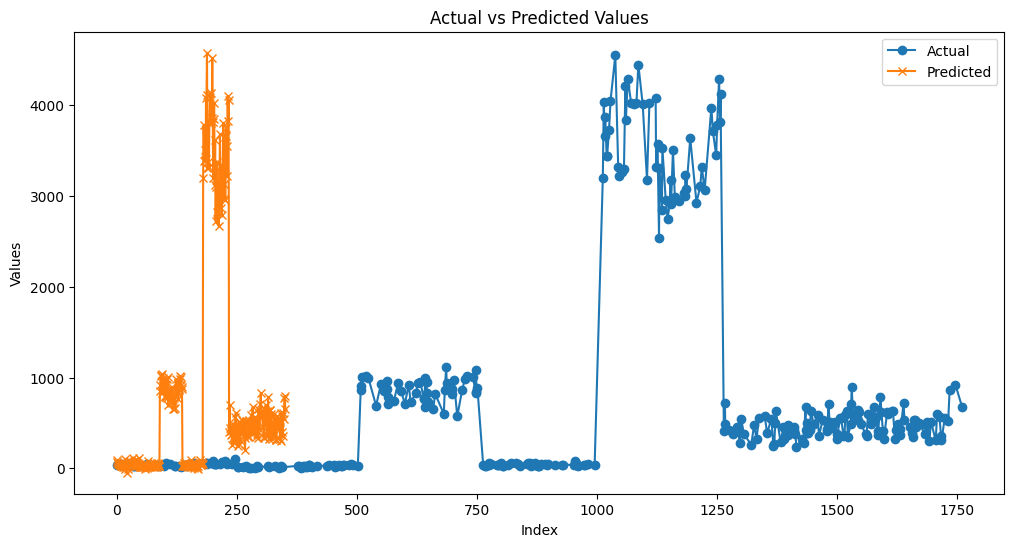

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

A R2 score of 0.9788 is good enough for me to go ahead and start with the deployment part of the task. Thus, committing the notebook and saving the lightgbm model.

In [43]:
bst.save_model('model.txt', num_iteration=bst.best_iteration)

In [44]:
import joblib
joblib.dump(bst, 'lgb.pkl')

['lgb.pkl']

In [45]:
df.rename(columns={'Date': 'ds', 'VALUE': 'y'}, inplace=True)

In [46]:
df.head()

,YEAR,MONTH,y,ds,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2020,1,28.0,2020-01-01,1,0,0,0,1,0
1,2020,2,40.0,2020-02-01,1,0,0,0,1,0
2,2020,3,27.0,2020-03-01,1,0,0,0,1,0
3,2020,4,26.0,2020-04-01,1,0,0,0,1,0
4,2020,5,40.0,2020-05-01,1,0,0,0,1,0


In [47]:
# # Split the data into training and testing sets
# df_sorted = df.sort_values(by='ds')
# train_percentage = 0.8
# split_index = int(len(df_sorted) * train_percentage)
# train_set = df_sorted[:split_index]
# test_set = df_sorted[split_index:]
# train_set = train_set.reset_index(drop=True)
# test_set = test_set.reset_index(drop=True)

# # Create and fit the model
# model = Prophet()
# model.fit(train_data)

# # Make predictions on the test set
# future = model.make_future_dataframe(periods=len(test_data))
# forecast = model.predict(future)

# # Evaluate the model
# y_true = test_data['y'].values
# y_pred = forecast['yhat'].tail(len(test_data)).values

# mse = mean_squared_error(y_true, y_pred)
# r2 = r2_score(y_true, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R2 Score: {r2}")

In [48]:
# # Fit ARMA model
# order = (p, q)  # Replace 'p' and 'q' with the desired order
# arma_model = sm.tsa.ARMA(train, order).fit()

# # Predict on the test set
# y_pred = arma_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# # Evaluate the model
# mse = mean_squared_error(test, y_pred)
# r2 = r2_score(test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R-squared: {r2}")
# print(arma_model.summary())  # Display model summary for additional information

In [49]:
# import tensorflow as tf
# print(tf.__version__)
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow_addons as tfa

# import os
# import json
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# from sklearn.model_selection import train_test_split
# import wandb
# from wandb.keras import WandbCallback

In [50]:
# def seed_everything():
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
#     np.random.seed(hash("improves reproducibility") % 2**32 - 1)
#     tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)
    
# seed_everything()

In [51]:
# # 3. Set hyperparameters

# TRAIN_PATH = '../input/resized-plant2021/img_sz_256/'
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# CONFIG = dict (
#     num_labels = 6,
#     train_val_split = 0.2,
#     img_width = 224,
#     img_height = 224,
#     batch_size = 64,
#     epochs = 10,
#     learning_rate = 0.001,
#     architecture = "CNN",
#     infra = "Kaggle",
#     competition = 'plant-pathology',
#     _wandb_kernel = 'ayut'
# )